In [1]:
import os
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
# Paths
DATASET_PATH = r"D:/FYP/Datasets/Paper sourced"
MFCC_OUTPUT_PATH = r"D:/FYP/Datasets/MFCC_Features"

# Ensure MFCC output directory exists
os.makedirs(MFCC_OUTPUT_PATH, exist_ok=True)

# Function to segment audio into 1-second clips
def segment_audio(file_path, segment_length=1, sr=48000):
    """Splits audio into 1-second segments and saves them in the same folder."""
    
    # Load audio file
    signal, sr = librosa.load(file_path, sr=sr)
    
    # Calculate total number of 1-second segments
    total_segments = int(np.floor(len(signal) / sr))

    if total_segments == 0:
        return []  # Skip files shorter than 1 sec

    output_folder = os.path.dirname(file_path)
    segmented_files = []
    
    for i in range(total_segments):
        start_sample = i * sr
        end_sample = (i + 1) * sr
        segment = signal[start_sample:end_sample]

        # Save each segment with a new name
        segment_filename = f"{os.path.basename(file_path).replace('.wav', '')}_seg_{i}.wav"
        segment_path = os.path.join(output_folder, segment_filename)
        sf.write(segment_path, segment, sr)  # Save as .wav
        segmented_files.append(segment_path)

    return segmented_files

In [3]:
# Function to extract and save MFCC features
def extract_mfcc(file_path, sr=48000, n_mfcc=13, max_pad_len=100):
    """Extracts MFCC features from an audio file and saves as .npy."""
    signal, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

    # Normalize feature length (pad/truncate)
    if mfccs.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_len]
    
    # Save MFCC features
    mfcc_filename = os.path.basename(file_path).replace(".wav", ".npy")
    mfcc_path = os.path.join(MFCC_OUTPUT_PATH, mfcc_filename)
    np.save(mfcc_path, mfccs)
    print(f"Saved MFCC: {mfcc_path}")

# Process all drones
for drone_folder in ["SegmentedAudio_HolybroS500", "SegmentedAudio_Matrice", 
                     "SegmentedAudio_Mavic", "SegmentedAudio_TarotX6_B1", "SegmentedAudio_TarotX6_B2","noise"]:
    
    folder_path = os.path.join(DATASET_PATH, drone_folder)
    print(f"Processing: {drone_folder}")

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            
            # Check if file is longer than 1 second
            signal, sr = librosa.load(file_path, sr=48000)
            if len(signal) > sr:  # Longer than 1 second
                segmented_files = segment_audio(file_path)
                os.remove(file_path)  # Delete the original file if it was segmented
                print(f"Segmented and deleted: {file_name}")
                
                # Extract MFCCs for each segmented file
                for segment_file in segmented_files:
                    extract_mfcc(segment_file)
            else:
                # Extract MFCC directly if already 1 second
                extract_mfcc(file_path)

print("Audio segmentation and MFCC extraction completed.")

Processing: SegmentedAudio_HolybroS500
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_1_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_2_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_3_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_4_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_5_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_6_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Ascent_7_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Back_1_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Back_2_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Back_3_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Back_4_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Back_5_seg_0.npy
Saved MFCC: D:/FYP/Datasets/MFCC_Features\HolybroS500_Back_6_seg_0.npy
Saved MFCC: D:/FYP/Datas

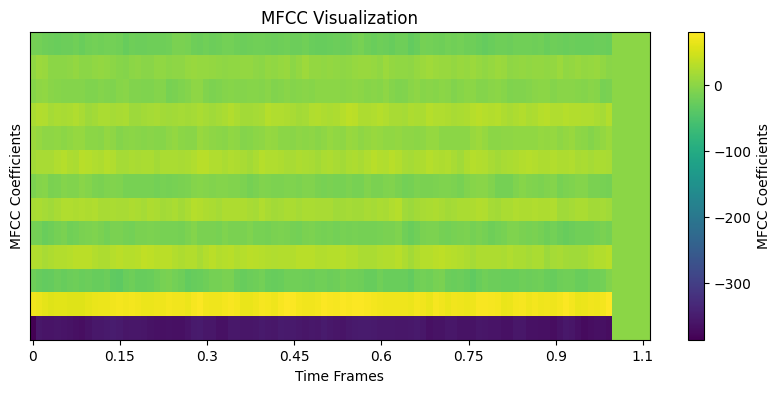

In [4]:
sample_mfcc_path = "D:/FYP/Datasets/MFCC_Features/DJIMavic2Enterprise_Yaw_2_seg_1.npy"  # Update with actual path
mfcc = np.load(sample_mfcc_path)

# Plot the MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis="time", sr=48000, cmap="viridis")
plt.colorbar(label="MFCC Coefficients")
plt.title("MFCC Visualization")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")
plt.show()

In [ ]:
# Paths
MFCC_PATH = r"D:/FYP/Datasets/MFCC_Features"

def extract_label(filename):
    if filename.startswith("1-"):
        return "noise"
    match = re.match(r"([A-Za-z0-9]+)_", filename)
    return match.group(1) if match else None

# Load MFCC features and labels
X, y = [], []
for file in os.listdir(MFCC_PATH):
    if file.endswith(".npy"):
        file_path = os.path.join(MFCC_PATH, file)
        mfcc_features = np.load(file_path)  # Load MFCC array

        # Flatten MFCC array into a 1D feature vector
        X.append(mfcc_features.flatten())

        # Extract drone type as label from filename
        label = extract_label(file)
        if label:
            y.append(label)

In [6]:
# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Encode labels numerically
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convert labels to numeric values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 92.27%

Classification Report:
                     precision    recall  f1-score   support

   DJIMatrice300RTK       0.90      0.93      0.91        28
DJIMavic2Enterprise       0.89      0.91      0.90        35
        HolybroS500       0.93      0.90      0.91        29
            TarotX6       0.92      0.91      0.91        64
              noise       1.00      1.00      1.00        25

           accuracy                           0.92       181
          macro avg       0.93      0.93      0.93       181
       weighted avg       0.92      0.92      0.92       181



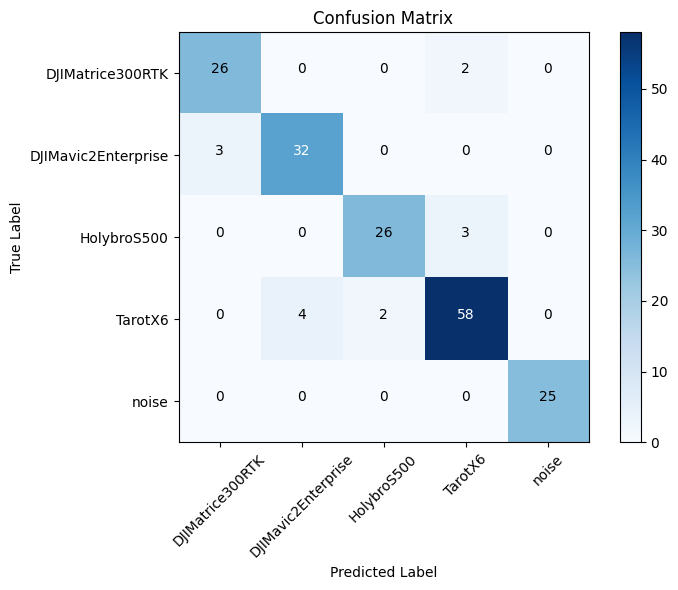

In [7]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = label_encoder.classes_

# Plot confusion matrix using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Annotate the confusion matrix cells with counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

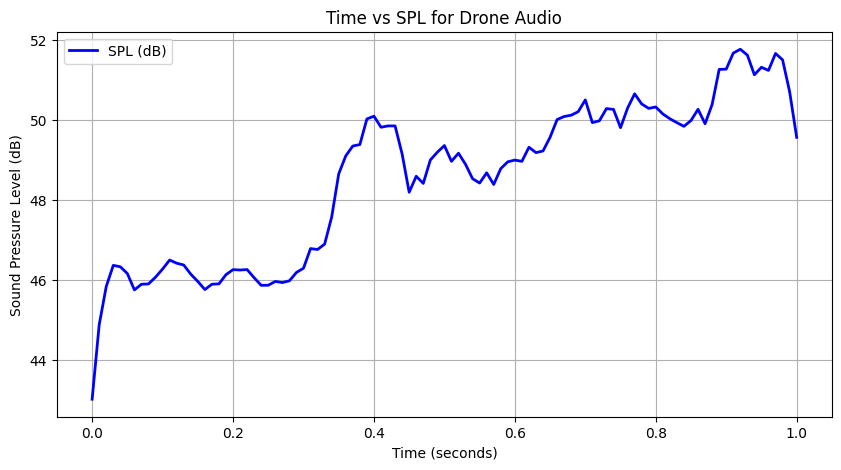

In [8]:
# Load the audio file
file_path = "D:/FYP/Datasets/Paper sourced/SegmentedAudio_HolybroS500/HolybroS500_Ascent_1_seg_0.wav"  # Replace with your actual .wav file
y, sr = librosa.load(file_path, sr=None)  # Load with original sampling rate

# Define frame length & hop length (e.g., 50ms frames)
frame_length = int(sr * 0.05)  # 50ms window
hop_length = int(sr * 0.01)    # 10ms step size

# Compute RMS (Root Mean Square) for each frame
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

# Convert RMS to SPL (Sound Pressure Level)
reference_pressure = 20e-6  # Reference pressure in air (20 µPa)
spl = 20 * np.log10(rms / reference_pressure + 1e-10)  # Add small offset to avoid log(0)

# Generate time axis for SPL values
time_axis = librosa.times_like(rms, sr=sr, hop_length=hop_length)

# Plot Time vs SPL
plt.figure(figsize=(10, 5))
plt.plot(time_axis, spl, label="SPL (dB)", color="b", linewidth=2)
plt.xlabel("Time (seconds)")
plt.ylabel("Sound Pressure Level (dB)")
plt.title("Time vs SPL for Drone Audio")
plt.grid()
plt.legend()
plt.show()